In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
warnings.filterwarnings('ignore')


## 1.Understanding Data

In [2]:
# Load and clean the data
df = pd.read_csv('household_power_consumption.csv')

In [3]:
# Display basic info
print("Data Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())

Data Shape: (1048575, 9)

Data Types:
 Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

Missing Values:
 Date                        0
Time                        0
Global_active_power         0
Global_reactive_power       0
Voltage                     0
Global_intensity            0
Sub_metering_1              0
Sub_metering_2              0
Sub_metering_3           4069
dtype: int64


In [3]:
df.columns = df.columns.str.lower()

In [4]:
# Convert columns to numeric, handling missing values marked with '?'
numeric_cols = ['global_active_power', 'global_reactive_power', 'voltage', 
               'global_intensity', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col].replace('?', np.nan), errors='coerce')

In [5]:
df.describe()

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
count,1.044506e+06,1.044506e+06,1.044506e+06,1.044506e+06,1.044506e+06,1.044506e+06,1.044506e+06
mean,1.108202e+00,1.182732e-01,2.399598e+02,4.718123e+00,1.177451e+00,1.475177e+00,5.933837e+00
std,1.129546e+00,1.095062e-01,3.284504e+00,4.763588e+00,6.321183e+00,6.352703e+00,8.210398e+00
min,7.600000e-02,0.000000e+00,2.234900e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.880000e-01,0.000000e+00,2.379700e+02,1.200000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.500000e-01,9.800000e-02,2.402100e+02,2.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.544000e+00,1.860000e-01,2.421400e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.067000e+01,1.390000e+00,2.521400e+02,4.640000e+01,8.000000e+01,7.800000e+01,3.100000e+01


### 2 Feature Engineering

In [5]:
# Convert Date and Time to datetime
df['dateTime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
df = df.drop(['date', 'time'], axis=1)

In [6]:
# Set DateTime as index
df.set_index('dateTime', inplace=True)

In [7]:
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['dayofyear'] = df.index.dayofyear

In [8]:
# Create lag features for time series
df['global_active_power_lag1'] = df['global_active_power'].shift(1).astype(float)
df['global_active_power_lag2'] = df['global_active_power'].shift(2).astype(float)
df['global_active_power_lag3'] = df['global_active_power'].shift(3).astype(float)

In [9]:
# Create rolling statistics
df['global_active_power_rolling_mean_24h'] = df['global_active_power'].rolling(window=24).mean().astype(float)
df['global_active_power_rolling_std_24h'] = df['global_active_power'].rolling(window=24).std().astype(float)

In [10]:
bins = [0, 6, 12, 18, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']
df['time_of_day'] = pd.cut(df['hour'], bins=bins, labels=labels, right=False)

In [11]:
df['intensity_level'] = pd.cut(df['global_intensity'], bins=[0, 5, 15, 30], labels=['low', 'medium', 'high'])


In [12]:
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

In [14]:
df

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3,hour,dayofweek,month,dayofyear,global_active_power_lag1,global_active_power_lag2,global_active_power_lag3,global_active_power_rolling_mean_24h,global_active_power_rolling_std_24h,time_of_day,intensity_level,is_weekend
dateTime,,,,,,,,,,,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,17,5,12,350,NaN,NaN,NaN,NaN,NaN,Afternoon,high,1
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,17,5,12,350,4.216,NaN,NaN,NaN,NaN,Afternoon,high,1
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,17,5,12,350,5.360,4.216,NaN,NaN,NaN,Afternoon,high,1
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,17,5,12,350,5.374,5.360,4.216,NaN,NaN,Afternoon,high,1
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,17,5,12,350,5.388,5.374,5.360,NaN,NaN,Afternoon,high,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-12-13 21:34:00,0.426,0.076,242.27,1.8,0.0,0.0,0.0,21,5,12,348,0.422,0.420,0.418,0.354583,0.045586,Evening,low,1
2008-12-13 21:35:00,0.424,0.076,242.10,1.8,0.0,0.0,0.0,21,5,12,348,0.426,0.422,0.420,0.358750,0.047210,Evening,low,1
2008-12-13 21:36:00,0.422,0.076,241.73,1.8,0.0,0.0,0.0,21,5,12,348,0.424,0.426,0.422,0.362917,0.048228,Evening,low,1


## 3. Exploratory Data Analysis (EDA)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1048575 entries, 2006-12-16 17:24:00 to 2008-12-13 21:38:00
Data columns (total 20 columns):
 #   Column                                Non-Null Count    Dtype   
---  ------                                --------------    -----   
 0   global_active_power                   1044506 non-null  float64 
 1   global_reactive_power                 1044506 non-null  float64 
 2   voltage                               1044506 non-null  float64 
 3   global_intensity                      1044506 non-null  float64 
 4   sub_metering_1                        1044506 non-null  float64 
 5   sub_metering_2                        1044506 non-null  float64 
 6   sub_metering_3                        1044506 non-null  float64 
 7   hour                                  1048575 non-null  int32   
 8   dayofweek                             1048575 non-null  int32   
 9   month                                 1048575 non-null  int32   
 10  dayofyear

In [21]:
# Summary statistics
print("\nSummary Statistics:\n", df.describe())


Summary Statistics:
        global_active_power  global_reactive_power       voltage  \
count         1.044506e+06           1.044506e+06  1.044506e+06   
mean          1.108202e+00           1.182732e-01  2.399598e+02   
std           1.129546e+00           1.095062e-01  3.284504e+00   
min           7.600000e-02           0.000000e+00  2.234900e+02   
25%           2.880000e-01           0.000000e+00  2.379700e+02   
50%           5.500000e-01           9.800000e-02  2.402100e+02   
75%           1.544000e+00           1.860000e-01  2.421400e+02   
max           1.067000e+01           1.390000e+00  2.521400e+02   

       global_intensity  sub_metering_1  sub_metering_2  sub_metering_3  \
count      1.044506e+06    1.044506e+06    1.044506e+06    1.044506e+06   
mean       4.718123e+00    1.177451e+00    1.475177e+00    5.933837e+00   
std        4.763588e+00    6.321183e+00    6.352703e+00    8.210398e+00   
min        2.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00   

In [22]:
df.columns

Index(['global_active_power', 'global_reactive_power', 'voltage',
       'global_intensity', 'sub_metering_1', 'sub_metering_2',
       'sub_metering_3', 'hour', 'dayofweek', 'month', 'dayofyear',
       'global_active_power_lag1', 'global_active_power_lag2',
       'global_active_power_lag3', 'global_active_power_rolling_mean_24h',
       'global_active_power_rolling_std_24h', 'time_of_day', 'intensity_level',
       'voltage_intensity', 'is_weekend'],
      dtype='object')

In [23]:
numeric_cols = ['global_active_power', 'global_reactive_power', 'voltage',
       'global_intensity', 'sub_metering_1', 'sub_metering_2',
       'sub_metering_3',
       'global_active_power_lag1', 'global_active_power_lag2',
       'global_active_power_lag3', 'global_active_power_rolling_mean_24h',
       'global_active_power_rolling_std_24h', 
       'voltage_intensity',]

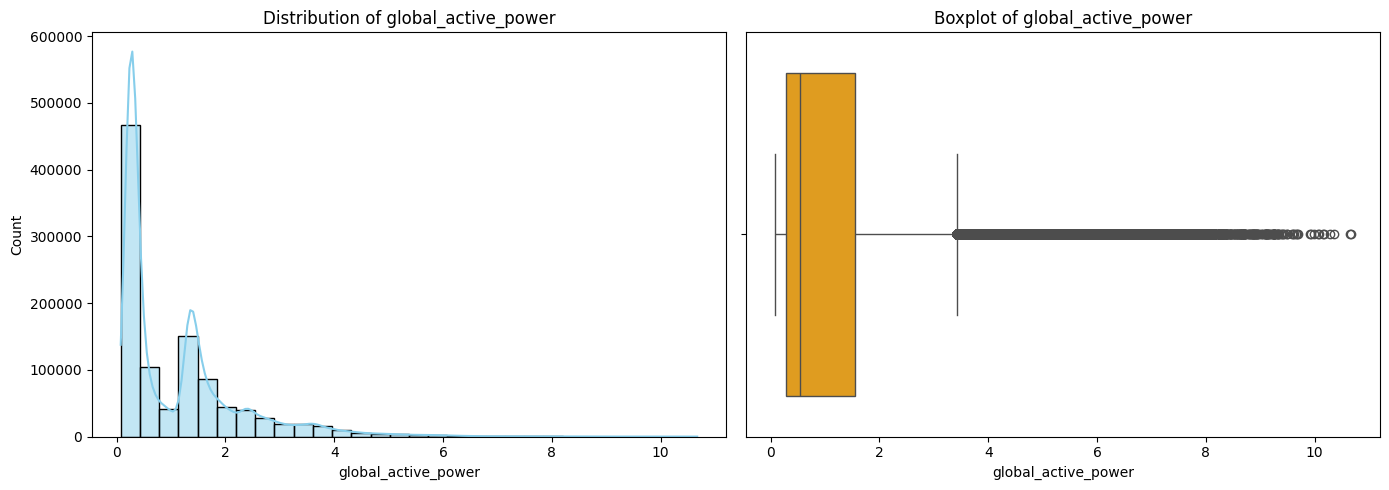

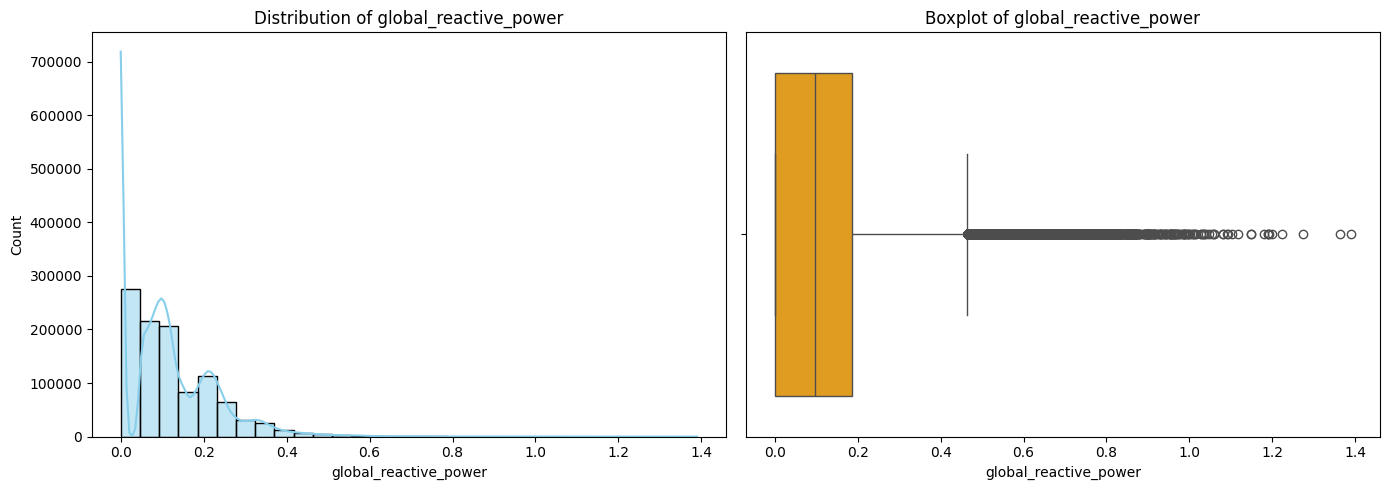

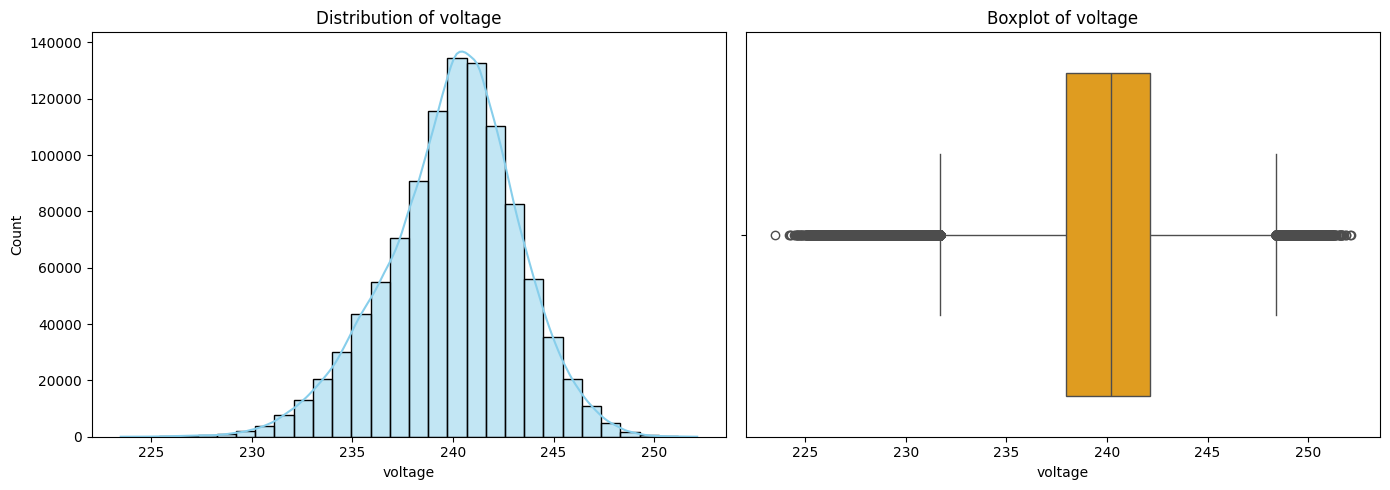

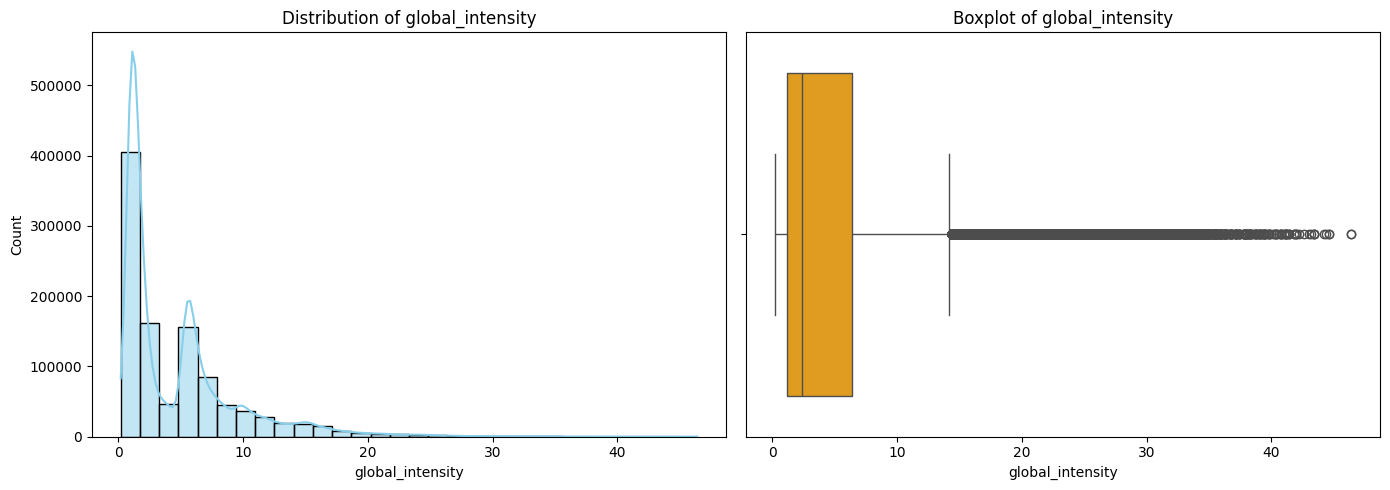

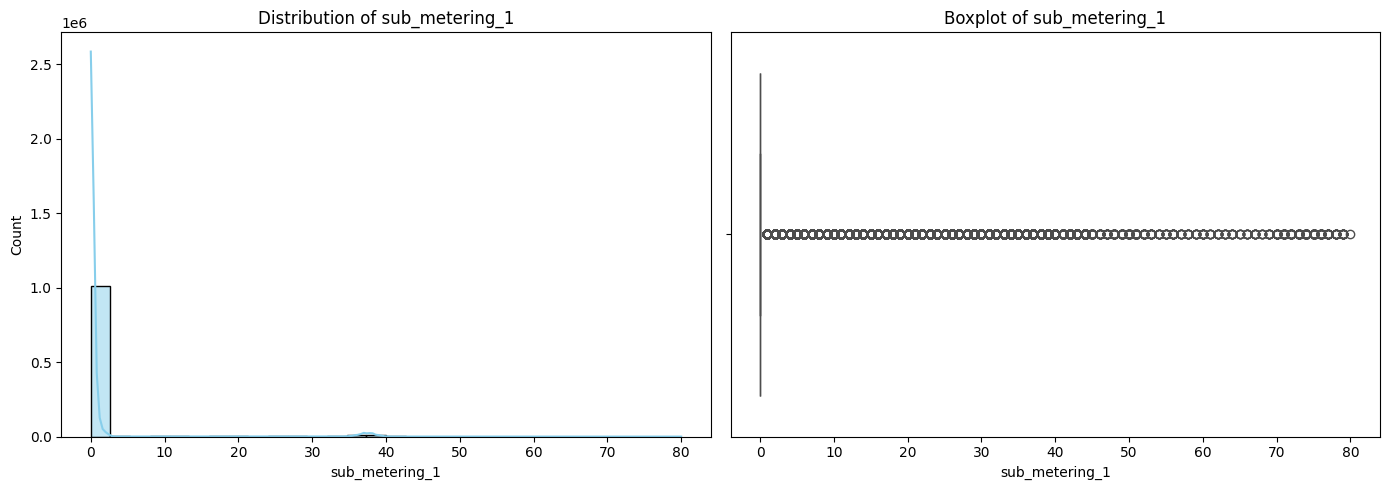

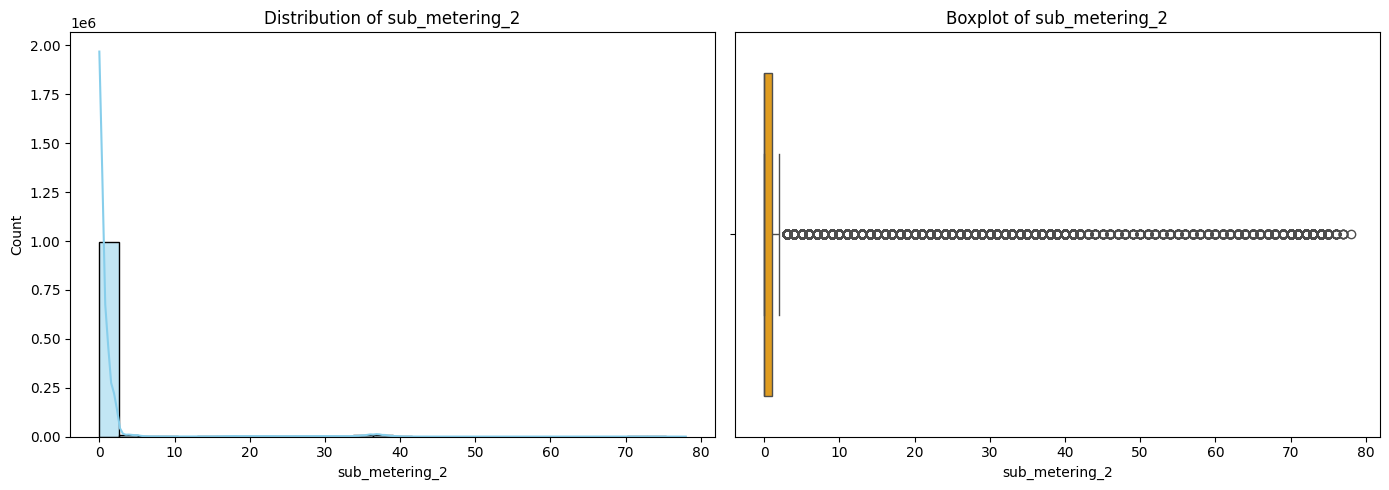

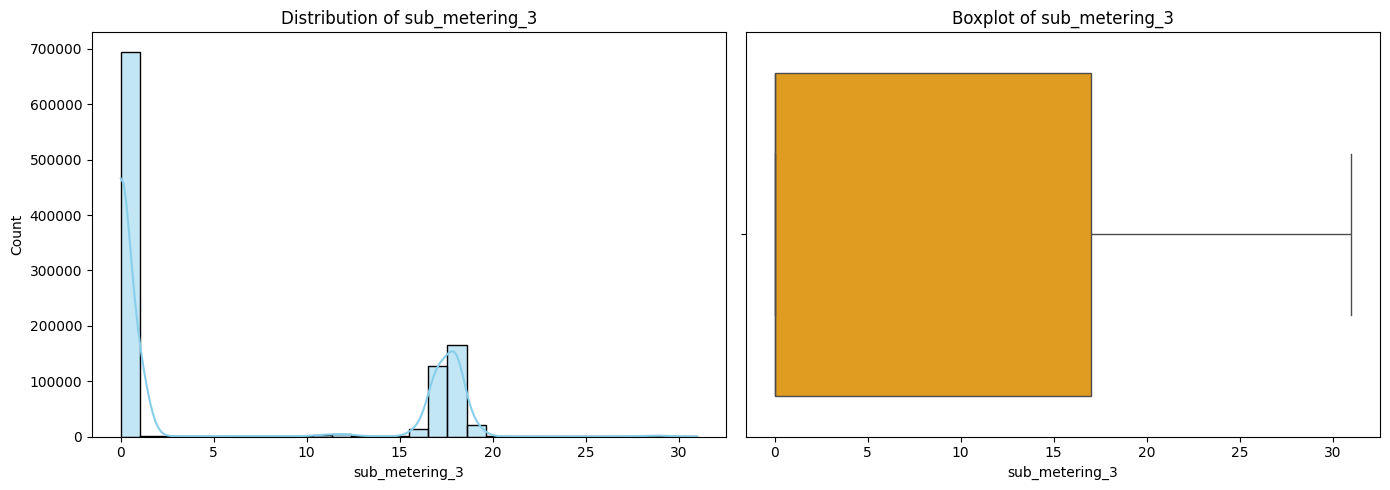

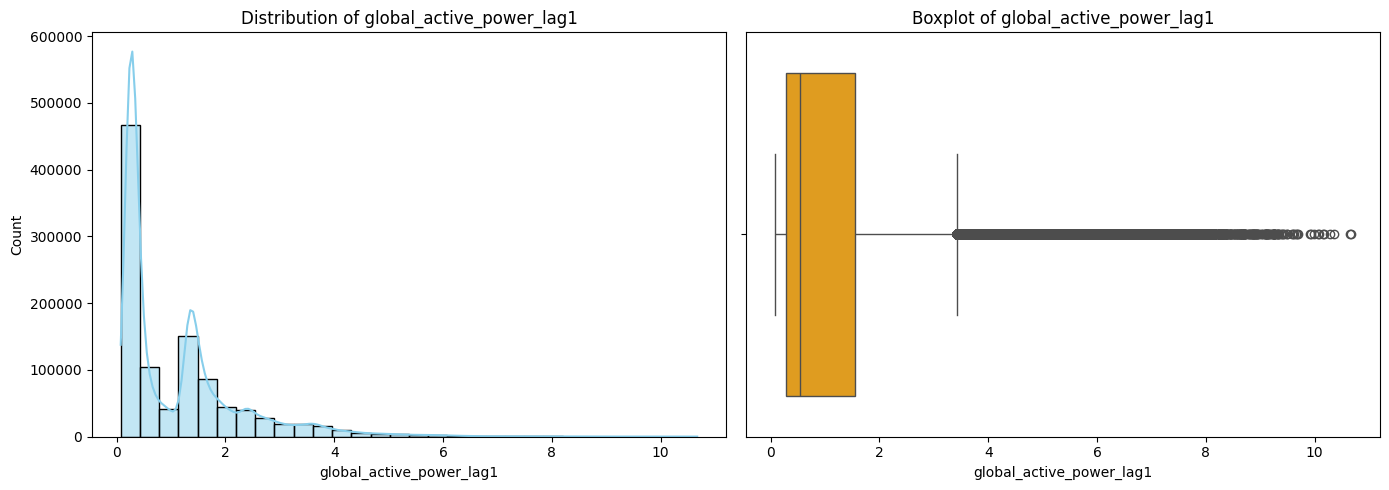

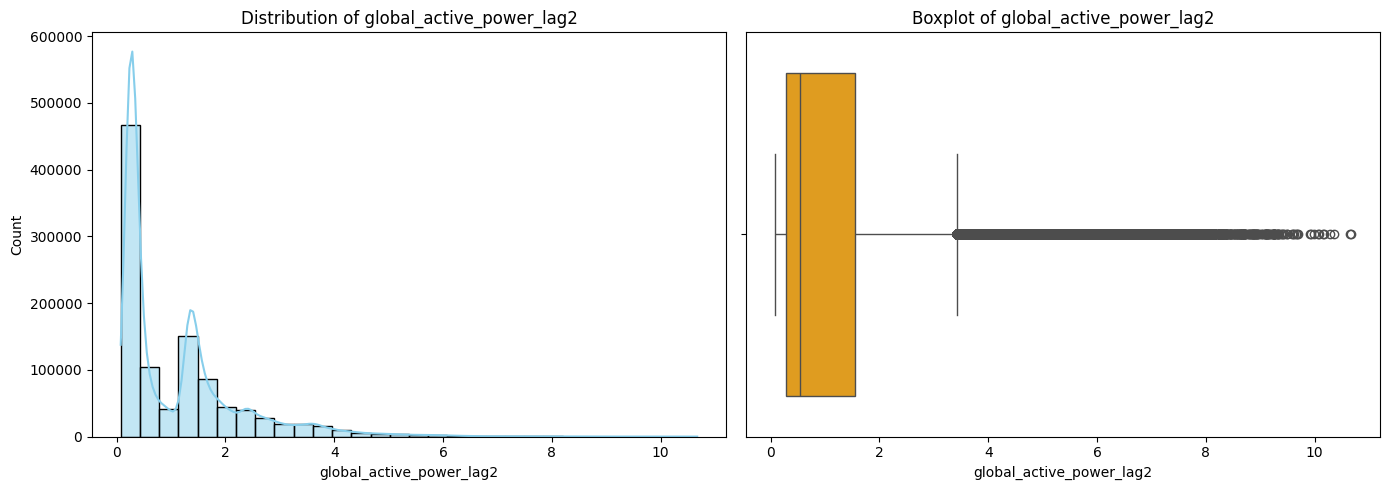

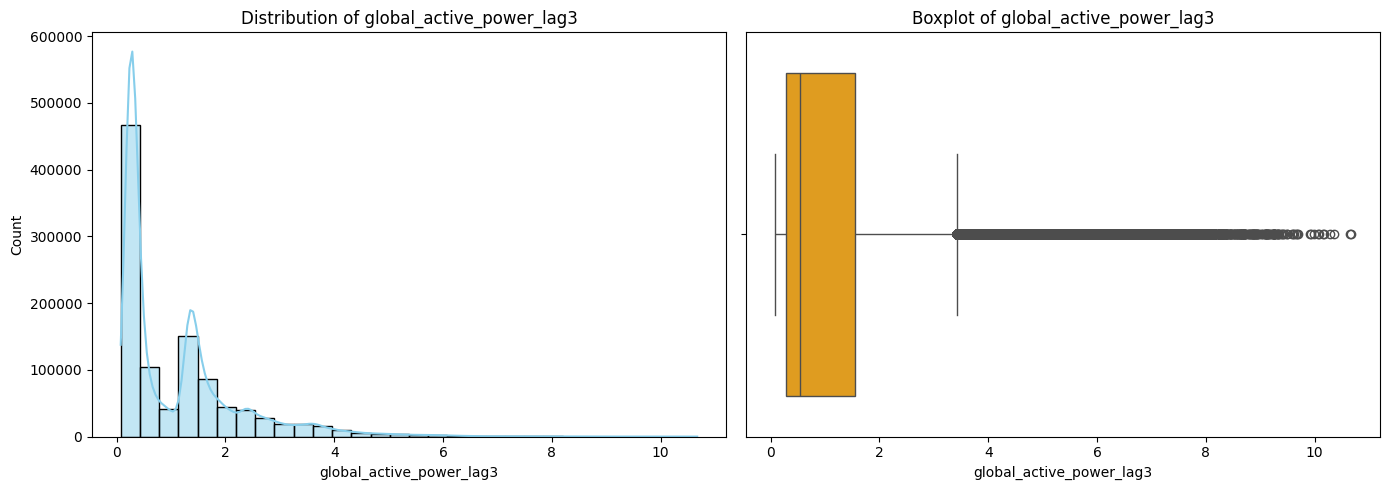

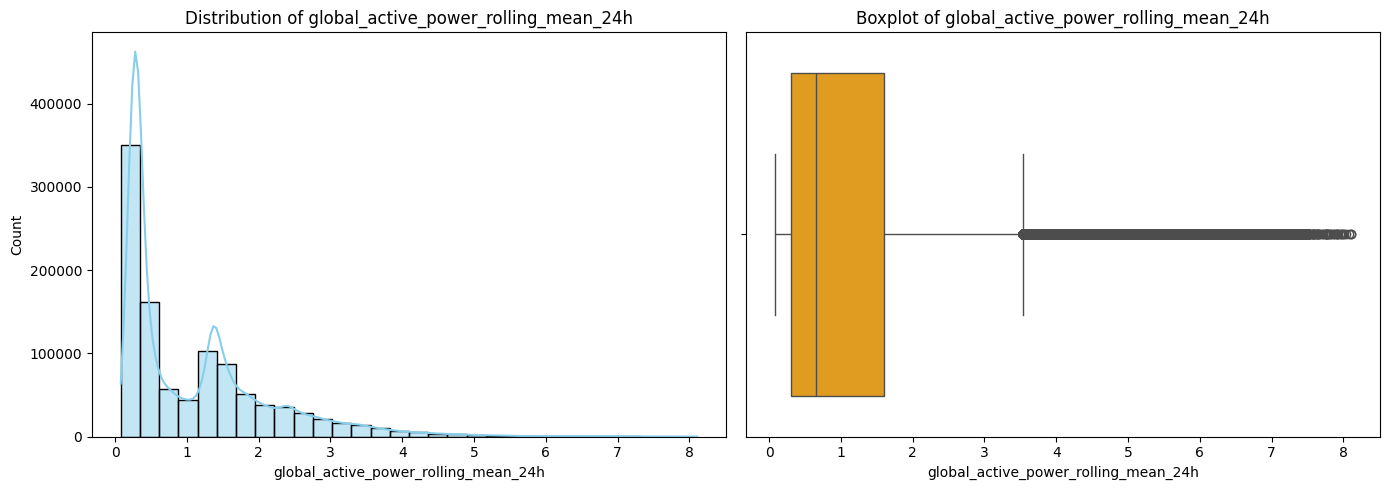

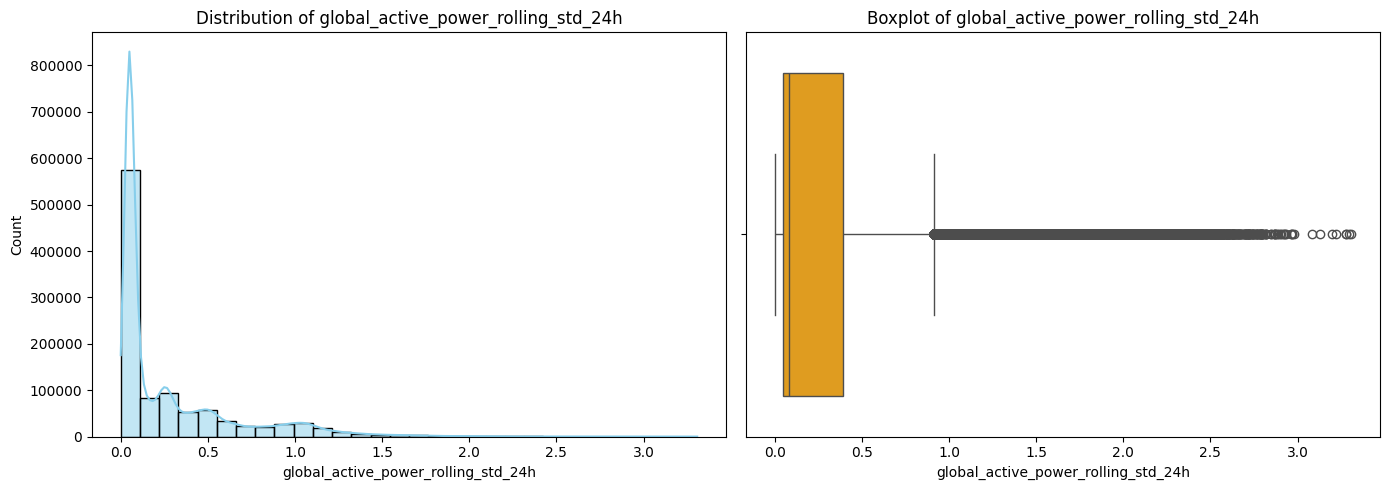

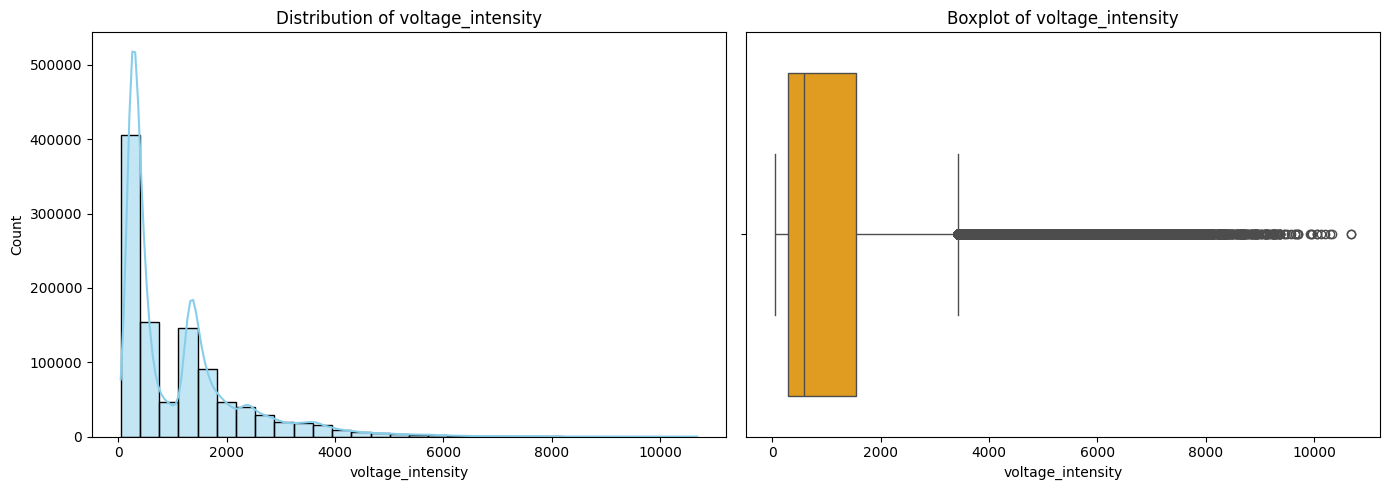

In [24]:
# Histogram and boxplot
for col in numeric_cols:
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col], color='orange')
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()

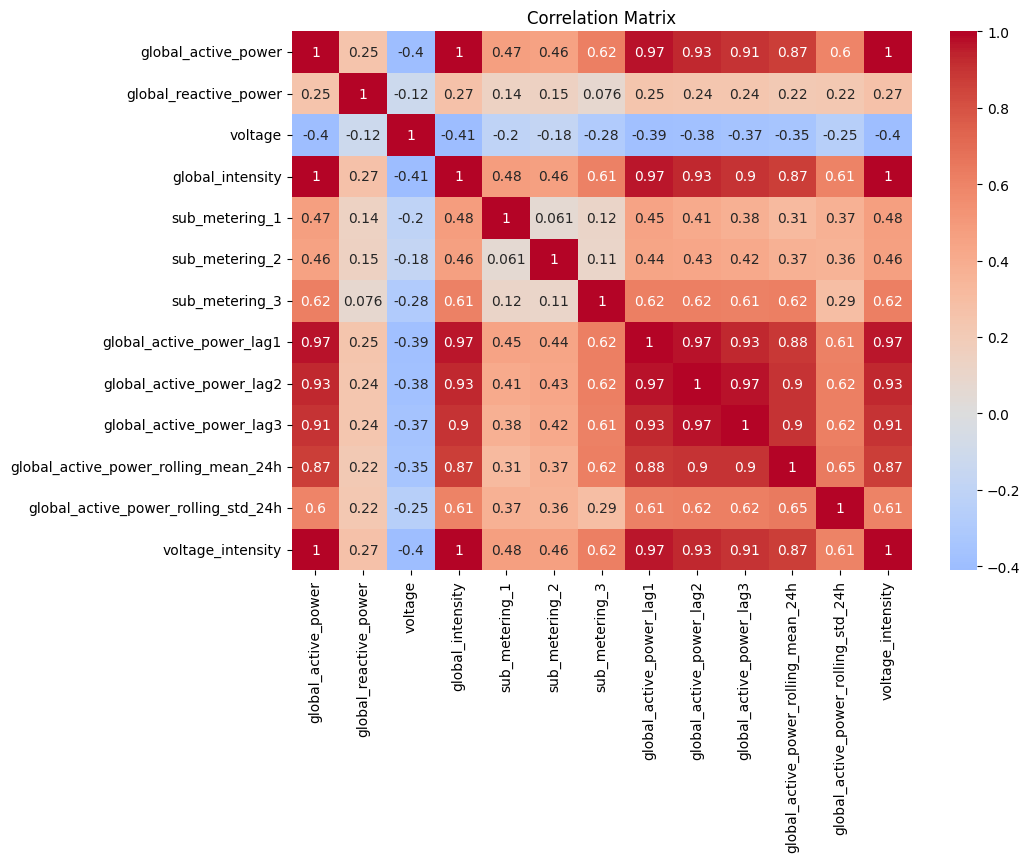

In [25]:
# 1. Correlation Heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()


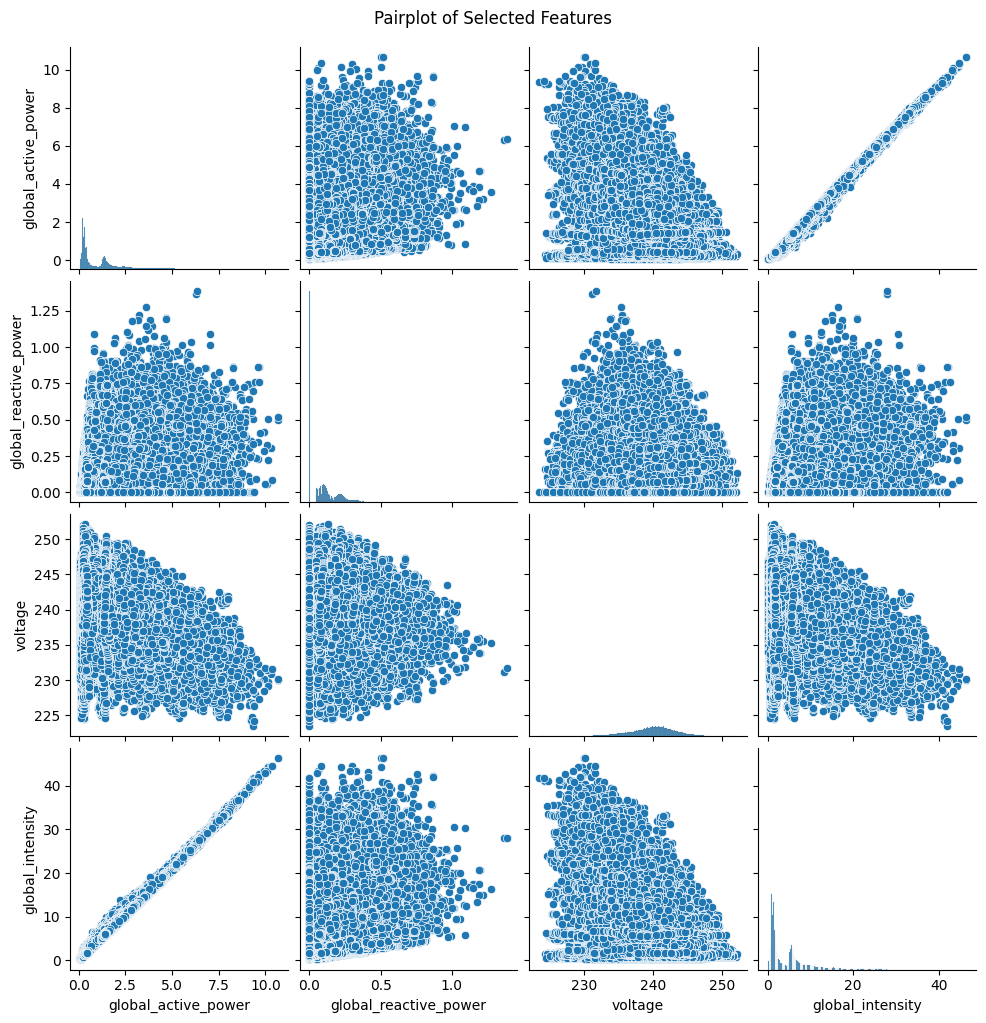

In [26]:
# 2. Pairplot (scatterplot matrix)
sns.pairplot(df[numeric_cols[:4]])  # Select subset to avoid clutter
plt.suptitle("Pairplot of Selected Features", y=1.02)
plt.show()

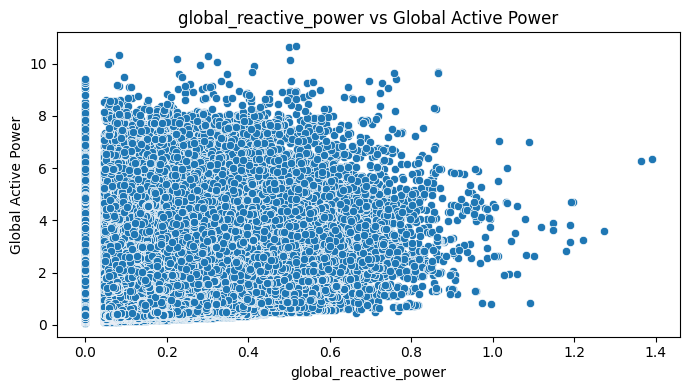

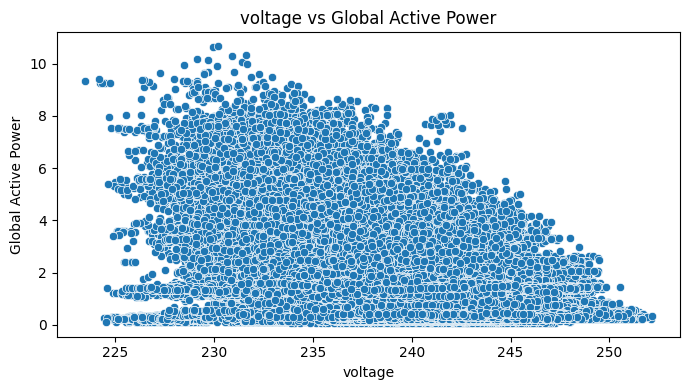

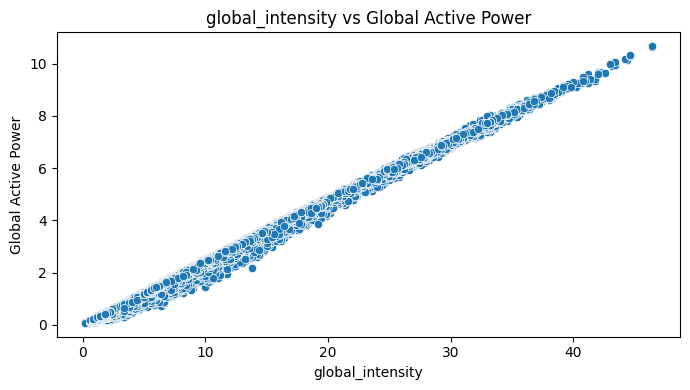

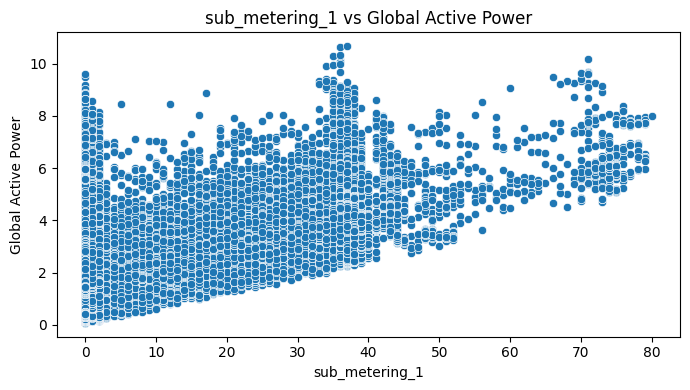

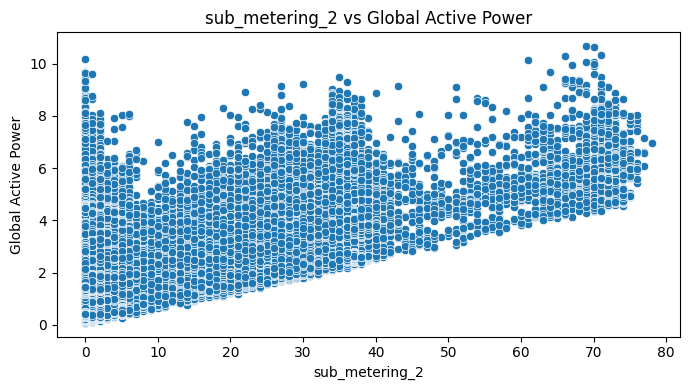

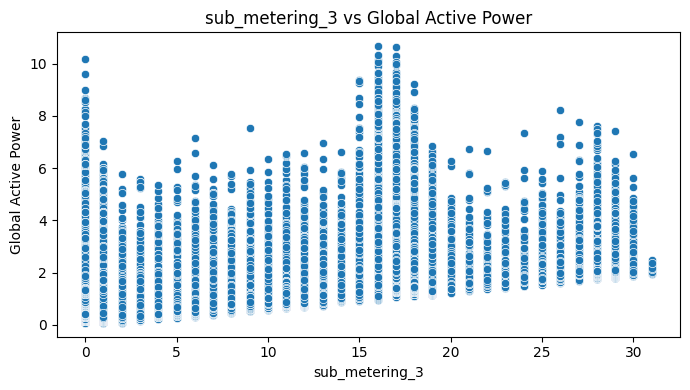

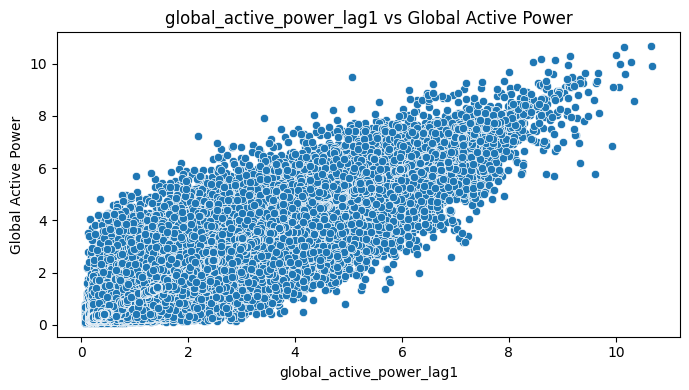

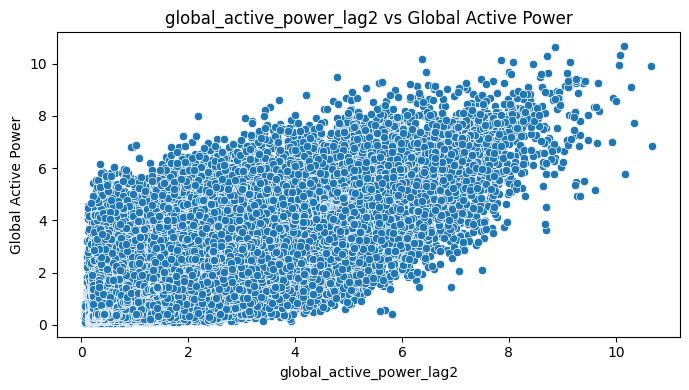

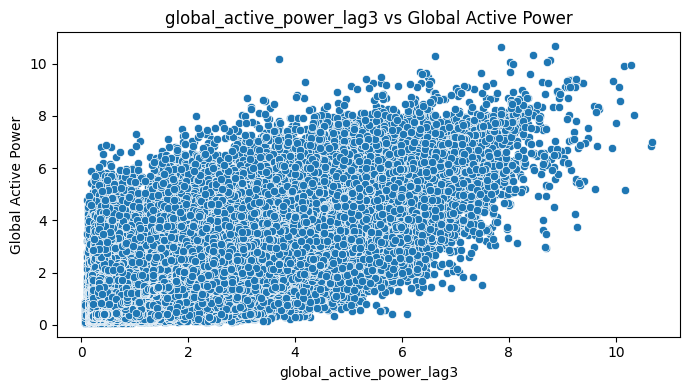

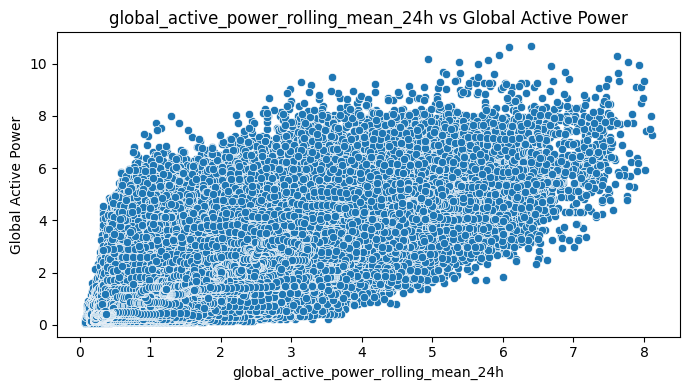

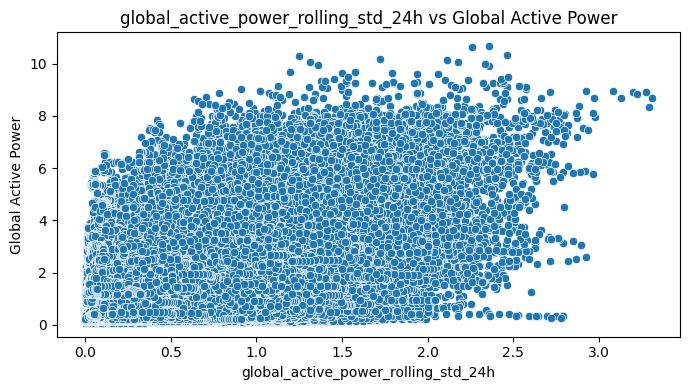

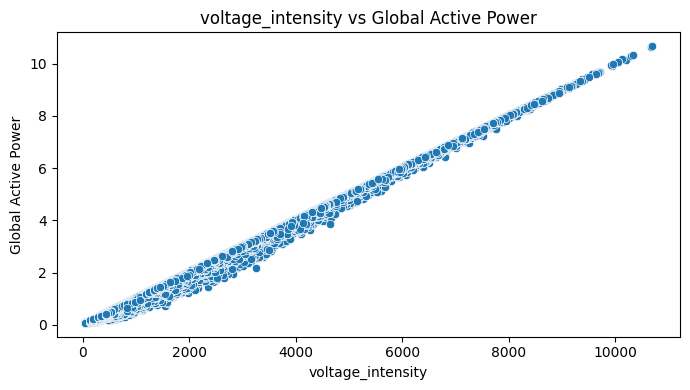

In [27]:
# 3. Scatterplots with target (if defined)
if 'global_active_power' in df.columns:
    for col in numeric_cols:
        if col != 'global_active_power':
            plt.figure(figsize=(7, 4))
            sns.scatterplot(x=df[col], y=df['global_active_power'])
            plt.title(f'{col} vs Global Active Power')
            plt.xlabel(col)
            plt.ylabel('Global Active Power')
            plt.tight_layout()
            plt.show()


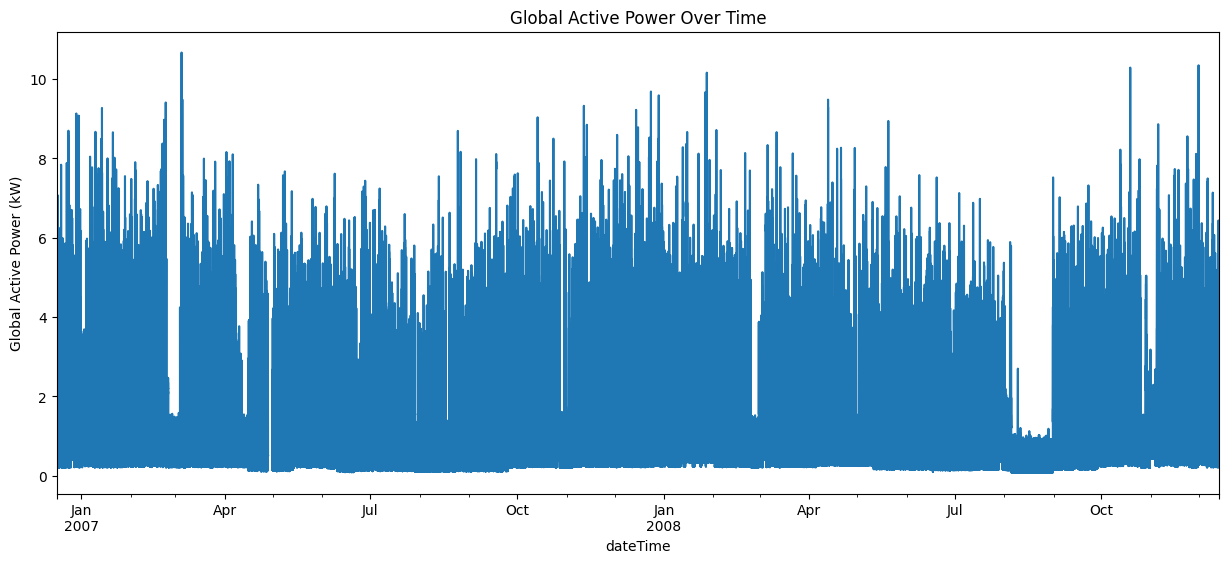

In [28]:
# Plot time series of Global_active_power
plt.figure(figsize=(15, 6))
df['global_active_power'].plot(title='Global Active Power Over Time')
plt.ylabel('Global Active Power (kW)')
plt.show()

<Figure size 1500x600 with 0 Axes>

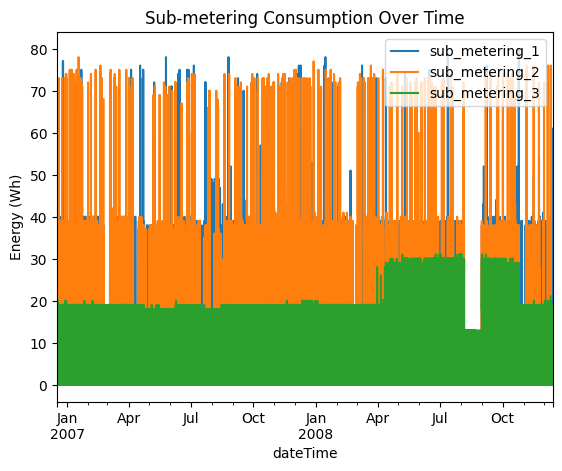

In [29]:
# Plot sub-metering consumption
plt.figure(figsize=(15, 6))
df[['sub_metering_1', 'sub_metering_2', 'sub_metering_3']].plot(title='Sub-metering Consumption Over Time')
plt.ylabel('Energy (Wh)')
plt.show()

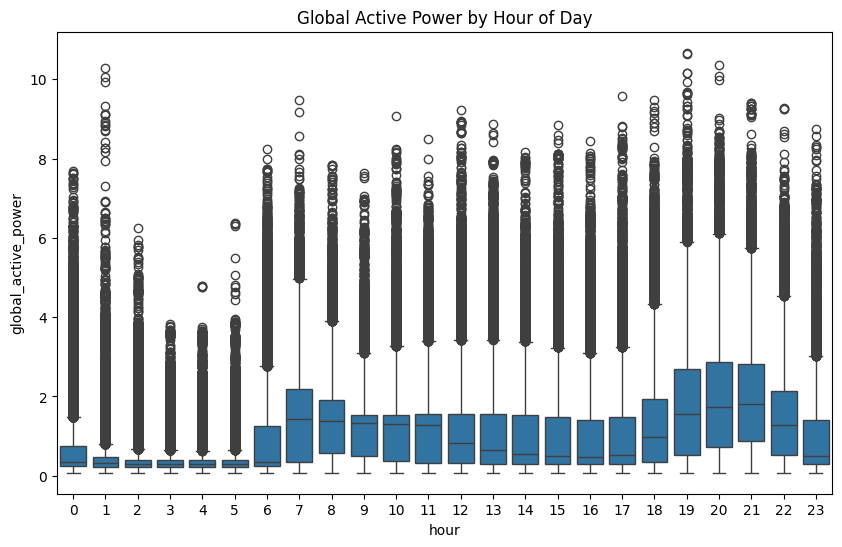

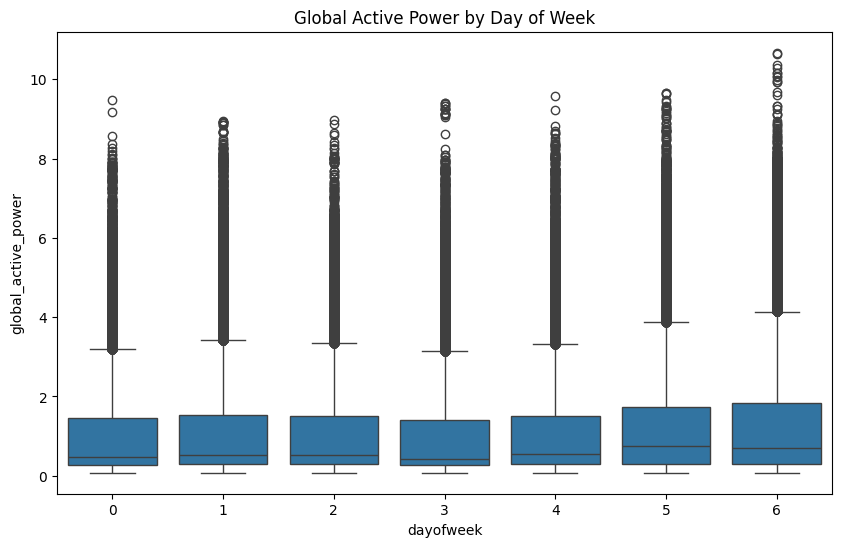

In [31]:
# 4. Boxplot for Categorical vs Numerical
plt.figure(figsize=(10, 6))
sns.boxplot(x='hour', y='global_active_power', data=df)
plt.title('Global Active Power by Hour of Day')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='dayofweek', y='global_active_power', data=df)
plt.title('Global Active Power by Day of Week')
plt.show()

## 4. Data Preprocessing for Machine Learning

In [13]:
df['target'] = df['global_active_power']


In [16]:
df.isna().sum()

global_active_power                     4069
global_reactive_power                   4069
voltage                                 4069
global_intensity                        4069
sub_metering_1                          4069
sub_metering_2                          4069
sub_metering_3                          4069
hour                                       0
dayofweek                                  0
month                                      0
dayofyear                                  0
global_active_power_lag1                4070
global_active_power_lag2                4071
global_active_power_lag3                4072
global_active_power_rolling_mean_24h    4950
global_active_power_rolling_std_24h     4950
time_of_day                                0
intensity_level                         5226
is_weekend                                 0
target                                  4069
dtype: int64

In [17]:
df.columns

Index(['global_active_power', 'global_reactive_power', 'voltage',
       'global_intensity', 'sub_metering_1', 'sub_metering_2',
       'sub_metering_3', 'hour', 'dayofweek', 'month', 'dayofyear',
       'global_active_power_lag1', 'global_active_power_lag2',
       'global_active_power_lag3', 'global_active_power_rolling_mean_24h',
       'global_active_power_rolling_std_24h', 'time_of_day', 'intensity_level',
       'is_weekend', 'target'],
      dtype='object')

In [14]:
# Split into features and target
X = df.drop(['target', 'global_active_power','global_intensity','global_active_power_lag1', 'global_active_power_lag2',
       'global_active_power_lag3','global_active_power_rolling_mean_24h'], axis=1)
y = df['target']

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((838860, 13), (209715, 13), (838860,), (209715,))

In [22]:
class LogTransformer(BaseEstimator, TransformerMixin):
    """Custom transformer for log transformation with handling of zeros"""
    def __init__(self, add_one=True):
        self.add_one = add_one
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.add_one:
            return np.log1p(X)
        else:
            return np.log(X)
    
    def inverse_transform(self, X):
        if self.add_one:
            return np.expm1(X)
        else:
            return np.exp(X)

In [97]:
y = y.fillna(y.median())

In [ ]:
y.n

np.int64(0)

In [21]:
X = X.fillna(method='ffill').fillna(method='bfill')

In [99]:
X.isna().sum()

global_reactive_power                  4069
voltage                                4069
sub_metering_1                         4069
sub_metering_2                         4069
sub_metering_3                         4069
hour                                      0
dayofweek                                 0
month                                     0
dayofyear                                 0
global_active_power_rolling_std_24h    4950
time_of_day                               0
intensity_level                        5226
is_weekend                                0
dtype: int64

## 4. Modeling

In [100]:
X.isna().sum()

global_reactive_power                  4069
voltage                                4069
sub_metering_1                         4069
sub_metering_2                         4069
sub_metering_3                         4069
hour                                      0
dayofweek                                 0
month                                     0
dayofyear                                 0
global_active_power_rolling_std_24h    4950
time_of_day                               0
intensity_level                        5226
is_weekend                                0
dtype: int64

In [101]:
numeric_features = ['global_reactive_power', 'voltage', 
                   'sub_metering_1', 'sub_metering_2', 'sub_metering_3','global_active_power_rolling_std_24h']

categorical_features = ['time_of_day', 'intensity_level', 'is_weekend']



In [103]:
# Create transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('power', PowerTransformer(method='yeo-johnson')) 
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])





In [104]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [105]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [119]:
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

In [ ]:
from sklearn.model_selection import GridSearchCV
# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=
    
    
    ,
    param_grid=param_grid,
    cv=2,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

In [108]:
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

Fitting 2 folds for each of 81 candidates, totalling 162 fits


KeyboardInterrupt: 

In [109]:
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [120]:
# Initialize Halving Grid Search
halving_search = HalvingGridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    factor=2,  
    scoring='neg_mean_squared_error',  
    cv=2,
    n_jobs=-1
)

In [121]:
halving_search.fit(X_train, y_train)

HalvingGridSearchCV(cv=2,
                    estimator=Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('num',
                                                                                Pipeline(steps=[('imputer',
                                                                                                 SimpleImputer(strategy='median')),
                                                                                                ('scaler',
                                                                                                 StandardScaler()),
                                                                                                ('power',
                                                                                                 PowerTransformer())]),
                                                                                ['global_reactive_power',
                                                                                 'voltage',
                                                                                 'sub_metering_1',
                                                                                 'sub_metering_2',
                                                                                 'sub_metering_3',
                                                                                 'global_active_power_rolling_std_24h']...
                                                                                                 OneHotEncoder(handle_unknown='ignore'))]),
                                                                                ['time_of_day',
                                                                                 'intensity_level',
                                                                                 'is_weekend'])])),
                                              ('regressor',
                                               RandomForestRegressor(random_state=42))]),
                    factor=2, n_jobs=-1,
                    param_grid={'regressor__max_depth': [None, 10, 20],
                                'regressor__min_samples_leaf': [1, 2, 4],
                                'regressor__min_samples_split': [2, 5, 10],
                                'regressor__n_estimators': [50, 100, 200]},
                    scoring='neg_mean_squared_error')

In [123]:
print("Best Parameters:", halving_search.best_params_)

Best Parameters: {'regressor__max_depth': 20, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 200}


In [126]:
best_model = halving_search.best_estimator_

In [127]:
y_pred = best_model.predict(X_test)

In [129]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test R²: {r2:.2f}")

Test RMSE: 0.30
Test MAE: 0.19
Test R²: 0.93


In [130]:
## save the model

import joblib
joblib.dump(best_model, 'best_random_forest_model.joblib')

['best_random_forest_model.joblib']

## 5. train and eval 

In [40]:
# Get feature names after preprocessing
preprocessor.fit(X_train)
feature_names = (numeric_features + 
                list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)))


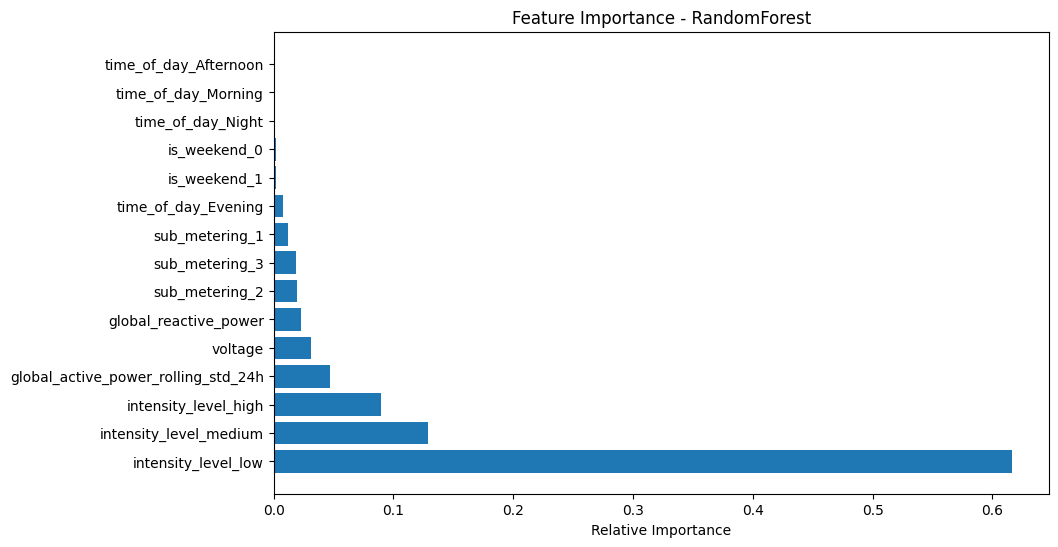

In [41]:
best_model_name = results_df['RMSE'].idxmin()
if best_model_name in ['RandomForest', 'XGBoost', 'LightGBM', 'GradientBoosting']:
    plot_feature_importance(models[best_model_name], feature_names, f'Feature Importance - {best_model_name}')

## 3. LSTM Modling

In [16]:
df.dropna(inplace=True)

## train test split

In [17]:
df['target'] = df["target"].shift(-1)

In [18]:
df.columns

Index(['global_active_power', 'global_reactive_power', 'voltage',
       'global_intensity', 'sub_metering_1', 'sub_metering_2',
       'sub_metering_3', 'hour', 'dayofweek', 'month', 'dayofyear',
       'global_active_power_lag1', 'global_active_power_lag2',
       'global_active_power_lag3', 'global_active_power_rolling_mean_24h',
       'global_active_power_rolling_std_24h', 'time_of_day', 'intensity_level',
       'is_weekend', 'target'],
      dtype='object')

In [ ]:
# Time-based split
train = df[df.index < '2008-06-02']  
test = df[df.index >= '2008-06-02']

In [ ]:
test.shape, train.shape

((280149, 18), (762325, 18))

In [25]:
# Separate features and target
X_train = train.drop('target', axis=1)
y_train = train['target']
X_test = test.drop('target', axis=1)
y_test = test['target']

In [26]:
from sklearn.preprocessing import MinMaxScaler
## 4. Scale Data
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

In [27]:
# Scale target separately
target_scaler = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = target_scaler.fit_transform(y_train)
y_test_scaled = target_scaler.transform(y_test)

In [28]:
## 5. Create Sequences
n_steps = 24  
n_features = X_train.shape

In [29]:
# Training sequences
X_train_seq, y_train_seq = [], []
for i in range(n_steps, len(X_train_scaled)):
    X_train_seq.append(X_train_scaled[i-n_steps:i, :])
    y_train_seq.append(y_train_scaled[i, 0])
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)

In [30]:
# Test sequences
X_test_seq, y_test_seq = [], []
for i in range(n_steps, len(X_test_scaled)):
    X_test_seq.append(X_test_scaled[i-n_steps:i, :])
    y_test_seq.append(y_test_scaled[i, 0])
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

In [34]:
# 1. Verify shapes before training
print(f"X_train_seq shape: {X_train_seq.shape}")  # Should be (samples, timesteps, features)
print(f"y_train shape: {y_train.shape}")  # Should be (samples,)

# 2. Align the shapes by trimming the longer array
min_samples = min(X_train_seq.shape[0], len(y_train))
X_train_seq = X_train_seq[:min_samples]
y_train = y_train[:min_samples]

# 3. Verify shapes after alignment
print("\nAfter alignment:")
print(f"X_train_seq shape: {X_train_seq.shape}")
print(f"y_train shape: {y_train.shape}")

# 4. Do the same for test data
min_test_samples = min(X_test_seq.shape[0], len(y_test))
X_test_seq = X_test_seq[:min_test_samples]
y_test = y_test[:min_test_samples]

# 5. Build the model
model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, 
         input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# 6. Train the model
history = model.fit(
    X_train_seq,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_seq, y_test),
    verbose=1
)

X_train_seq shape: (762301, 24, 17)
y_train shape: (762325, 1)

After alignment:
X_train_seq shape: (762301, 24, 17)
y_train shape: (762301, 1)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 24, 100)        │        47,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,451 (302.54 KB)

 Trainable params: 77,451 (302.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
23822/23822 ━━━━━━━━━━━━━━━━━━━━ 570s 24ms/step - loss: 0.0638 - val_loss: 0.0032
Epoch 2/10
23822/23822 ━━━━━━━━━━━━━━━━━━━━ 705s 30ms/step - loss: 0.0155 - val_loss: 0.0032
Epoch 3/10
23822/23822 ━━━━━━━━━━━━━━━━━━━━ 678s 28ms/step - loss: 0.0146 - val_loss: 0.0029
Epoch 4/10
23822/23822 ━━━━━━━━━━━━━━━━━━━━ 739s 31ms/step - loss: 0.0141 - val_loss: 0.0027
Epoch 5/10
23822/23822 ━━━━━━━━━━━━━━━━━━━━ 683s 29ms/step - loss: 0.0138 - val_loss: 0.0021
Epoch 6/10
23822/23822 ━━━━━━━━━━━━━━━━━━━━ 656s 28ms/step - loss: 0.0138 - val_loss: 0.0021
Epoch 7/10
23822/23822 ━━━━━━━━━━━━━━━━━━━━ 694s 29ms/step - loss: 0.0136 - val_loss: 0.0050
Epoch 8/10
23822/23822 ━━━━━━━━━━━━━━━━━━━━ 814s 34ms/step - loss: 0.0134 - val_loss: 0.0037
Epoch 9/10
23822/23822 ━━━━━━━━━━━━━━━━━━━━ 869s 34ms/step - loss: 0.0134 - val_loss: 0.0027
Epoch 10/10
23822/23822 ━━━━━━━━━━━━━━━━━━━━ 865s 36ms/step - loss: 0.0132 - val_loss: 0.0043


In [35]:
y_pred_scaled = model.predict(X_test_seq)

8754/8754 ━━━━━━━━━━━━━━━━━━━━ 75s 9ms/step


In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, y_pred_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_scaled))
r2 = r2_score(y_test, y_pred_scaled)


In [46]:
print("\nModel Evaluation Scores:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²) Score: {r2:.4f}")



Model Evaluation Scores:
Mean Absolute Error (MAE): 0.0534
Root Mean Squared Error (RMSE): 0.0659
R-squared (R²) Score: 0.9956


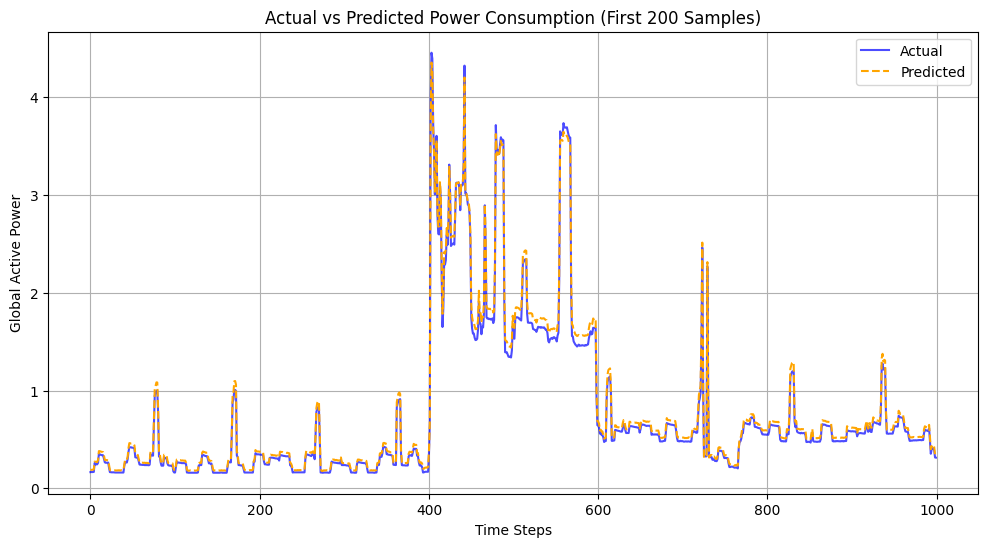

In [56]:
## 9. Plot Results
plt.figure(figsize=(12, 6))
plt.plot(y_test[:1000], label='Actual', color='blue', alpha=0.7)
plt.plot(y_pred_scaled[:1000], label='Predicted', color='orange', linestyle='--')
plt.title("Actual vs Predicted Power Consumption (First 200 Samples)")
plt.xlabel("Time Steps")
plt.ylabel("Global Active Power")
plt.legend()
plt.grid(True)
plt.show()


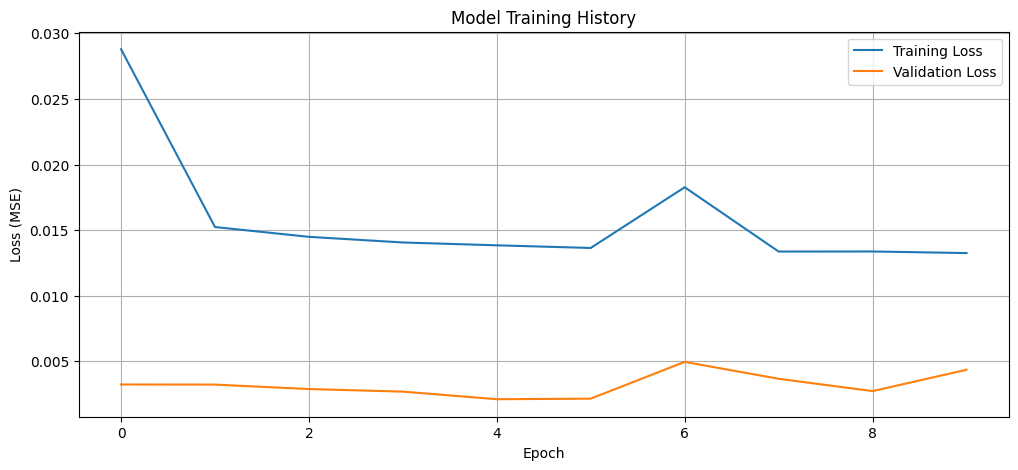

In [49]:
# 4. Plot training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [58]:
df.to_csv('processed_household_power_consumption.csv', index=False)